In [81]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import signal

In [82]:
data_files = glob.glob("*.log")
print(len(data_files), data_files)

22 ['matt1-stair-60r.log', 'matt2-2r.log', 'matt2-standr.log', 'paul-standl.log', 'nick2-25l.log', 'abby2-2r.log', 'abby1-sitr.log', 'matt2-21l.log', 'paul-sitr.log', 'matt2-sitl.log', 'abby1-standl.log', 'abby1-stair-48r.log', 'paul-sitl.log', 'matt2-sitr.log', 'matt1-stair-66l.log', 'abby1-stair-72l.log', 'abby1-standr.log', 'abby2-22l.log', 'matt2-standl.log', 'paul-standr.log', 'nick2-25r.log', 'abby1-sitl.log']


In [110]:
WINDOW_SIZE = 110
WINDOW_STEP = 20

phrase = "Acc X"
phrase2 = "Time taken by the task: 25 milliseconds"
phrase3 = "Time taken by the task: 24 milliseconds"
cols = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z']

sample_rate = 1/0.025 # Hz
num_channels = 9
ten_minutes =round(10*60*num_channels*sample_rate) #mins*seconds/min*num_channels*samples/second+ 1(python index start 0)
i = 0

train_X = []
train_Y = []
test_X = []
test_Y = []
testSubject = 'paul'
testSubject2 = 'nick'

for file in data_files:
    print(file)
    
    data = []
    with open(file) as f:
        f = f.readlines()

    for line in f[1:]:
        # Want to start beginning with x-acceleration measurements so data is alligned properly
        if line[:-1] == phrase:
            start = True
        if phrase not in line and phrase2 not in line and phrase3 not in line and start:
            data.append(float(line[:-1]))
    
    data = data[:ten_minutes]
    data = np.array(data)
    data = data.reshape((-1,9))
    print(data.shape)

    # Split into non-overlapping windows
    # Don't use the last bit of data that doesn't fill a whole window
    n_windows = data.shape[0] // WINDOW_SIZE
    end = WINDOW_SIZE * n_windows
    data = data[:end,:]

    # Split into overlapping windows
    data = np.lib.stride_tricks.sliding_window_view(data, WINDOW_SIZE, axis=0)[::WINDOW_STEP]
    data = data.transpose(0,2,1)
    print(data.shape)
    
    # upstairs
    if i==0 or i==11 or i==14 or i==15:
        data_y = 3*np.ones((data.shape[0], data.shape[1]))
    # walking
    if i==1 or i==4 or i==5 or i==7 or i==17 or i==20:
        data_y = 2*np.ones((data.shape[0], data.shape[1]))
    # standing
    if i==2 or i==3 or i==10 or i==16 or i==18 or i==19:
        data_y = np.ones((data.shape[0], data.shape[1]))
    # sitting    
    if i==6 or i==8 or i==9 or i==12 or i==13 or i==21:
        data_y = np.zeros((data.shape[0], data.shape[1]))
        
    i += 1
    
    if file[:4] == testSubject or file[:4] == testSubject2:
        print('Adding '+file+' to test set')
        test_X.append(data)
        test_Y.append(data_y)
    else:
        train_X.append(data)
        train_Y.append(data_y)

np.random.seed(0)
shuffle_indices_train = np.random.permutation(len(train_X))
shuffle_indices_test = np.random.permutation(len(test_X))

train_X = np.concatenate(train_X, axis=0)
train_Y = np.concatenate(train_Y, axis=0)
test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)

shuffle_indices_train = np.random.permutation(train_X.shape[0])
shuffle_indices_test = np.random.permutation(test_X.shape[0])

train_X = train_X[shuffle_indices_train]
train_Y = train_Y[shuffle_indices_train]
test_X = test_X[shuffle_indices_test]
test_Y = test_Y[shuffle_indices_test]
print(train_X.shape, test_X.shape)


matt1-stair-60r.log
(24000, 9)
(1194, 110, 9)
matt2-2r.log
(18235, 9)
(903, 110, 9)
matt2-standr.log
(24000, 9)
(1194, 110, 9)
paul-standl.log
(24000, 9)
(1194, 110, 9)
Adding paul-standl.log to test set
nick2-25l.log
(24000, 9)
(1194, 110, 9)
Adding nick2-25l.log to test set
abby2-2r.log
(24000, 9)
(1194, 110, 9)
abby1-sitr.log
(24000, 9)
(1194, 110, 9)
matt2-21l.log
(24000, 9)
(1194, 110, 9)
paul-sitr.log
(24000, 9)
(1194, 110, 9)
Adding paul-sitr.log to test set
matt2-sitl.log
(24000, 9)
(1194, 110, 9)
abby1-standl.log
(24000, 9)
(1194, 110, 9)
abby1-stair-48r.log
(24000, 9)
(1194, 110, 9)
paul-sitl.log
(24000, 9)
(1194, 110, 9)
Adding paul-sitl.log to test set
matt2-sitr.log
(24000, 9)
(1194, 110, 9)
matt1-stair-66l.log
(24000, 9)
(1194, 110, 9)
abby1-stair-72l.log
(24000, 9)
(1194, 110, 9)
abby1-standr.log
(24000, 9)
(1194, 110, 9)
abby2-22l.log
(24000, 9)
(1194, 110, 9)
matt2-standl.log
(24000, 9)
(1194, 110, 9)
paul-standr.log
(24000, 9)
(1194, 110, 9)
Adding paul-standr.log to 

In [111]:
sample_x = train_X[7000,:,0]
x_stretch = signal.resample(sample_x, int(len(sample_x) * 1.1))
x_squeeze = signal.resample(sample_x, int(len(sample_x) * 0.9))
x_shrink = sample_x * 0.8
x_scaled = sample_x * 1.2

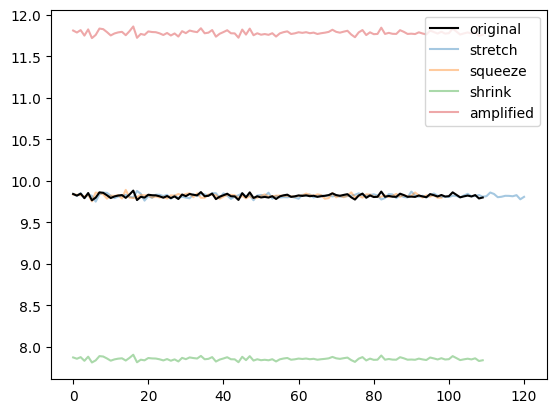

In [112]:
plt.plot(sample_x, label="original", zorder=4, c='k')
plt.plot(x_stretch, label="stretch", alpha=0.4)
plt.plot(x_squeeze, label="squeeze", alpha=0.4)
plt.plot(x_shrink, label="shrink", alpha=0.4)
plt.plot(x_scaled, label="amplified", alpha=0.4)
plt.legend()
plt.show()

In [113]:
class IMUDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        return inputs, labels


class IMUDataAugment:
    """
    Collate function to apply random time stretch/squeeze and signal shrink/scale
    Apply stretch/squeeze to the time dimension by resampling and truncating to out_samples
        The lower bound of stretch must satisfy (lb * len(input)) > out_samples
    """
    def __init__(self, out_samples=80, p=0.5, stretch=(0.8, 1.2), scale=(0.8, 1.2)):
        """
        Parameters:
        -----------
        p: float between [0, 1], probability of applying each the stretch and scale transform independently
        strech: tuple of float, upper and lower bound on time stretch factor
        scale: tuple of float, upper and lower bound on signal scale factor
        """
        self.p = p
        self.stretch = stretch
        self.scale = scale
        self.out_samples = out_samples
    

    def _random_crop(self, inputs, labels):
        """Apply a random crop of the signal of length self.out_samples to both inputs and labels"""
        n, d = inputs.shape
        max_offset = n - self.out_samples
        offset = np.random.choice(max_offset)
        inds = slice(offset, offset + self.out_samples)
        return inputs[inds, :], labels[inds]

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (inputs, labels) of length batch_size
            inputs: np.ndarray, dimensions (n_samples, n_channels), signal data
            labels: np.ndarray, dimensions (n_samples,), binary label vector for the signal data

        Returns:
        --------
        (inputs, labels): augmented signal data, reduced labels
        """
        x = []
        y = []
        for (inputs, labels) in data:
            
            n, d = inputs.shape
            assert (self.stretch[0] * n) >= self.out_samples, f"input size {n} must be greater than {int(self.out_samples / self.stretch[0])} to apply augmentation"

            # Randomly apply time stretch
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.stretch
                stretch = np.random.uniform(lb, ub)
                inputs = signal.resample(inputs, int(n * stretch), axis=0)  # Resample the time (n_samples) axis
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.scale
                scale = np.random.uniform(lb, ub)
                inputs = scale * inputs  # Scale all channels equally
            
            # Apply random crop to self.out_size on both inputs and labels
            inputs, labels = self._random_crop(inputs, labels)

            x.append(inputs)
            y.append(labels.mean())
            
        collated_inputs = torch.tensor(x, dtype=torch.float32)
        collated_labels = torch.tensor(y, dtype=torch.float32)
        

        return collated_inputs, collated_labels

In [114]:
train_dataset = IMUDataset(train_X, train_Y)
test_dataset = IMUDataset(test_X, test_Y)

augment_fn = IMUDataAugment(out_samples=80)
test_augment = IMUDataAugment(out_samples=80, p=0)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=augment_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_augment)
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [115]:
train_X.shape

(18813, 110, 9)

In [116]:
train_Y.shape

(18813, 110)

In [117]:
import torch.nn.functional as f

def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets = torch.tensor(targets.flatten(), dtype=torch.int64)
        labels = targets
        targets = f.one_hot(targets,4)
        outputs = model(inputs.double())
        loss = criterion(outputs.double(), targets.double())
        loss.backward()
        optimizer.step()

        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.argmax(outputs,dim=1)
        correct += torch.sum(preds == labels).detach().cpu()

        if i % logging_steps == 0:
            print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

In [118]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import matplotlib.pyplot as plt

def evaluate(model, dataloader, criterion, epoch, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets = torch.tensor(targets.flatten(), dtype=torch.int64)
            labels = targets
            targets = f.one_hot(targets,4)
            outputs = model(inputs.double())
            loss = criterion(outputs.double(), targets.double())

            total_loss += loss
            preds = torch.argmax(outputs,dim=1)
            
            
            correct += torch.sum(preds == labels).detach().cpu()
            all_preds.append(preds.flatten().numpy())
            all_labels.append(labels.flatten().numpy())
            
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0) 
        cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
        disp.plot()
        plt.show()
            
        
        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Epoch {epoch} done. Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)

In [119]:
# Classes
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bi):
        super(GRUModel, self).__init__()

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bi
        )

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)

    def forward(self, x):
        
        out, _ = self.gru(x)

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out.flatten(start_dim=-2))

        return torch.sigmoid(out)
    
    
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bi):
        super(LSTMModel, self).__init__()

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bi
        )

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)

    def forward(self, x):

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x)

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out.flatten(start_dim=-2))

        return torch.sigmoid(out)

0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
9it [00:00, 41.51it/s]

Epoch: 0 (0/294) Training loss: 1.4004098617105967


29it [00:00, 45.39it/s]

Epoch: 0 (20/294) Training loss: 1.0187758775671636


49it [00:01, 45.72it/s]

Epoch: 0 (40/294) Training loss: 0.9418135984053352


69it [00:01, 46.04it/s]

Epoch: 0 (60/294) Training loss: 0.9106112778685655


89it [00:01, 46.45it/s]

Epoch: 0 (80/294) Training loss: 0.8503991570841946


109it [00:02, 46.39it/s]

Epoch: 0 (100/294) Training loss: 0.8433191621348265


129it [00:02, 46.28it/s]

Epoch: 0 (120/294) Training loss: 0.8131382530356265


149it [00:03, 46.21it/s]

Epoch: 0 (140/294) Training loss: 0.8100648727342705


169it [00:03, 46.72it/s]

Epoch: 0 (160/294) Training loss: 0.8046799795683861


189it [00:04, 46.54it/s]

Epoch: 0 (180/294) Training loss: 0.7748455739712072


209it [00:04, 46.58it/s]

Epoch: 0 (200/294) Training loss: 0.7765585964897513


229it [00:04, 46.65it/s]

Epoch: 0 (220/294) Training loss: 0.7748599862616555


249it [00:05, 43.46it/s]

Epoch: 0 (240/294) Training loss: 0.7749162058853846


269it [00:05, 45.28it/s]

Epoch: 0 (260/294) Training loss: 0.7709975275319746


289it [00:06, 46.16it/s]

Epoch: 0 (280/294) Training loss: 0.7683161901994757


294it [00:06, 45.73it/s]


Epoch 0 done. Training loss: 0.8512251552561613 Training accuracy: 0.9116709232330322


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
112it [00:01, 88.96it/s]


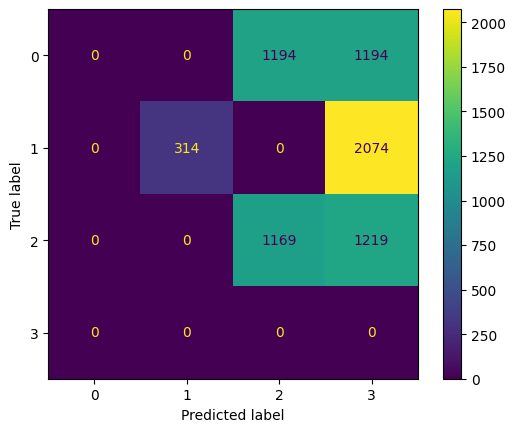

Epoch 0 done. Eval loss: 1.5104811291246172 Eval accuracy: 0.2068917453289032


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 34.72it/s]

Epoch: 1 (0/294) Training loss: 0.7619343584745717


29it [00:00, 45.07it/s]

Epoch: 1 (20/294) Training loss: 0.7618639209109863


49it [00:01, 44.56it/s]

Epoch: 1 (40/294) Training loss: 0.7690805386685668


69it [00:01, 46.25it/s]

Epoch: 1 (60/294) Training loss: 0.7659871810614232


89it [00:01, 46.53it/s]

Epoch: 1 (80/294) Training loss: 0.7670523055702925


109it [00:02, 46.51it/s]

Epoch: 1 (100/294) Training loss: 0.7723809129258254


129it [00:02, 46.62it/s]

Epoch: 1 (120/294) Training loss: 0.759202361699932


149it [00:03, 46.49it/s]

Epoch: 1 (140/294) Training loss: 0.7600081554084704


169it [00:03, 46.56it/s]

Epoch: 1 (160/294) Training loss: 0.7611392049941763


189it [00:04, 46.93it/s]

Epoch: 1 (180/294) Training loss: 0.7613875307239765


209it [00:04, 46.99it/s]

Epoch: 1 (200/294) Training loss: 0.7546151549415676


229it [00:04, 46.90it/s]

Epoch: 1 (220/294) Training loss: 0.7546635822990582


249it [00:05, 46.65it/s]

Epoch: 1 (240/294) Training loss: 0.7506116856900739


269it [00:05, 46.23it/s]

Epoch: 1 (260/294) Training loss: 0.7519914755128667


289it [00:06, 46.35it/s]

Epoch: 1 (280/294) Training loss: 0.7526678090895963


294it [00:06, 46.05it/s]


Epoch 1 done. Training loss: 0.7596389752572859 Training accuracy: 0.9985119104385376


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
112it [00:01, 85.92it/s]


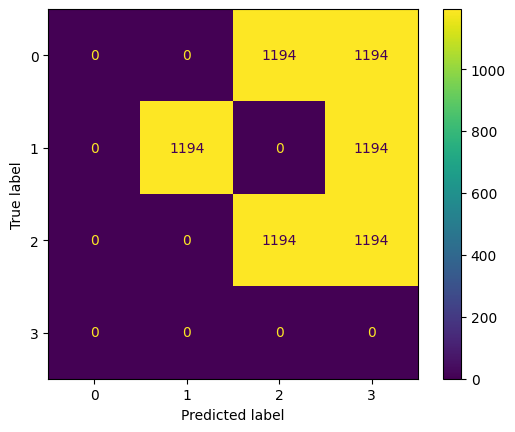

Epoch 1 done. Eval loss: 1.3394757449831158 Eval accuracy: 0.3331473171710968


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 39.27it/s]

Epoch: 2 (0/294) Training loss: 0.7493255498559062


29it [00:00, 44.90it/s]

Epoch: 2 (20/294) Training loss: 0.7492648521249237


49it [00:01, 45.10it/s]

Epoch: 2 (40/294) Training loss: 0.751432949320185


69it [00:01, 46.04it/s]

Epoch: 2 (60/294) Training loss: 0.7499360971913875


89it [00:01, 46.27it/s]

Epoch: 2 (80/294) Training loss: 0.7498832962766355


109it [00:02, 46.11it/s]

Epoch: 2 (100/294) Training loss: 0.7492824047143373


129it [00:02, 46.37it/s]

Epoch: 2 (120/294) Training loss: 0.7499687626487346


149it [00:03, 46.28it/s]

Epoch: 2 (140/294) Training loss: 0.7488401087142501


169it [00:03, 46.90it/s]

Epoch: 2 (160/294) Training loss: 0.7489011886517541


189it [00:04, 46.74it/s]

Epoch: 2 (180/294) Training loss: 0.7490952505790904


209it [00:04, 47.07it/s]

Epoch: 2 (200/294) Training loss: 0.7481889615742076


229it [00:04, 46.61it/s]

Epoch: 2 (220/294) Training loss: 0.7484226756475871


249it [00:05, 46.48it/s]

Epoch: 2 (240/294) Training loss: 0.7495436957837002


269it [00:05, 46.60it/s]

Epoch: 2 (260/294) Training loss: 0.7487625341651514


289it [00:06, 46.54it/s]

Epoch: 2 (280/294) Training loss: 0.7491045001783245


294it [00:06, 46.09it/s]


Epoch 2 done. Training loss: 0.7496074241928972 Training accuracy: 0.9998405575752258


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
112it [00:01, 88.21it/s]


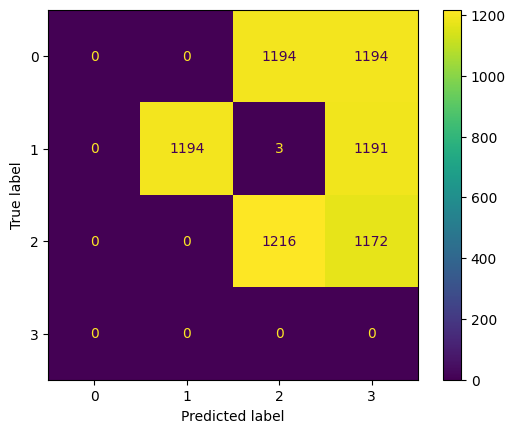

Epoch 2 done. Eval loss: 1.4111705709396711 Eval accuracy: 0.3362165093421936


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 38.64it/s]

Epoch: 3 (0/294) Training loss: 0.7487137985317968


29it [00:00, 45.25it/s]

Epoch: 3 (20/294) Training loss: 0.7484629195736587


49it [00:01, 45.20it/s]

Epoch: 3 (40/294) Training loss: 0.7487277979531317


69it [00:01, 45.71it/s]

Epoch: 3 (60/294) Training loss: 0.7490431582393636


89it [00:01, 46.48it/s]

Epoch: 3 (80/294) Training loss: 0.7483046471172593


109it [00:02, 46.45it/s]

Epoch: 3 (100/294) Training loss: 0.7483122982474884


129it [00:02, 46.74it/s]

Epoch: 3 (120/294) Training loss: 0.7488337078309568


149it [00:03, 46.48it/s]

Epoch: 3 (140/294) Training loss: 0.7485692192908323


169it [00:03, 46.73it/s]

Epoch: 3 (160/294) Training loss: 0.7486925775912786


189it [00:04, 46.77it/s]

Epoch: 3 (180/294) Training loss: 0.7480459747127441


209it [00:04, 46.88it/s]

Epoch: 3 (200/294) Training loss: 0.7478721569018506


229it [00:04, 46.81it/s]

Epoch: 3 (220/294) Training loss: 0.7481076170597072


249it [00:05, 46.61it/s]

Epoch: 3 (240/294) Training loss: 0.748463805487213


269it [00:05, 46.52it/s]

Epoch: 3 (260/294) Training loss: 0.7480054709894299


289it [00:06, 46.64it/s]

Epoch: 3 (280/294) Training loss: 0.7487260906195197


294it [00:06, 46.11it/s]


Epoch 3 done. Training loss: 0.7483826943607514 Training accuracy: 0.9998405575752258


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
112it [00:01, 86.73it/s]


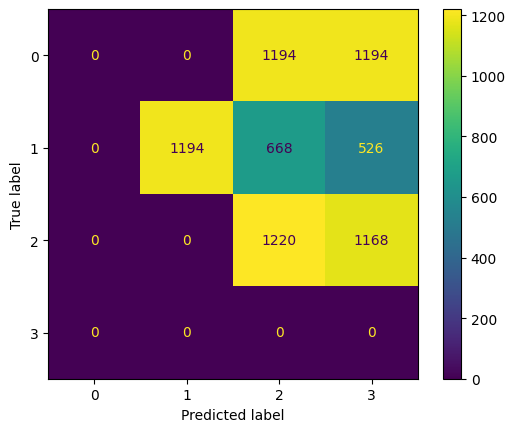

Epoch 3 done. Eval loss: 1.4383913553010252 Eval accuracy: 0.3367745578289032


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 36.39it/s]

Epoch: 4 (0/294) Training loss: 0.747766950557438


29it [00:00, 44.81it/s]

Epoch: 4 (20/294) Training loss: 0.7480938773527939


49it [00:01, 45.51it/s]

Epoch: 4 (40/294) Training loss: 0.7481319995618747


69it [00:01, 45.98it/s]

Epoch: 4 (60/294) Training loss: 0.7476822722555485


89it [00:01, 46.55it/s]

Epoch: 4 (80/294) Training loss: 0.7479549119291815


109it [00:02, 46.75it/s]

Epoch: 4 (100/294) Training loss: 0.7478434871705173


129it [00:02, 46.68it/s]

Epoch: 4 (120/294) Training loss: 0.7478928547455364


149it [00:03, 46.92it/s]

Epoch: 4 (140/294) Training loss: 0.748372756136266


169it [00:03, 46.85it/s]

Epoch: 4 (160/294) Training loss: 0.7479411004472647


189it [00:04, 47.12it/s]

Epoch: 4 (180/294) Training loss: 0.7480235757846891


209it [00:04, 46.68it/s]

Epoch: 4 (200/294) Training loss: 0.7480802556459546


229it [00:04, 46.82it/s]

Epoch: 4 (220/294) Training loss: 0.7483081129815019


249it [00:05, 46.68it/s]

Epoch: 4 (240/294) Training loss: 0.749124790912111


269it [00:05, 46.81it/s]

Epoch: 4 (260/294) Training loss: 0.7481292730486101


289it [00:06, 46.56it/s]

Epoch: 4 (280/294) Training loss: 0.7599429909231039


294it [00:06, 46.25it/s]


Epoch 4 done. Training loss: 0.748447140302795 Training accuracy: 0.9998405575752258


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
112it [00:01, 88.02it/s]


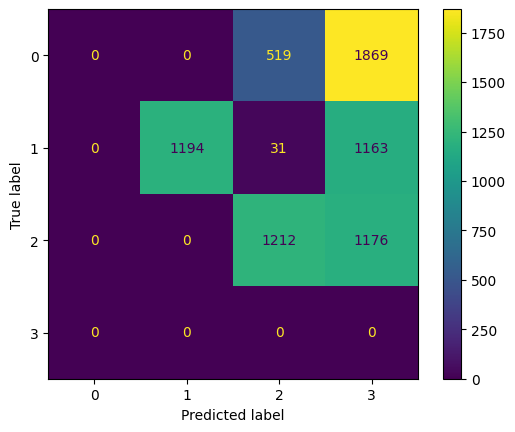

Epoch 4 done. Eval loss: 1.4571696387543998 Eval accuracy: 0.3356584906578064


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 39.95it/s]

Epoch: 5 (0/294) Training loss: 0.7508276439872168


29it [00:00, 44.75it/s]

Epoch: 5 (20/294) Training loss: 0.7484031883218131


49it [00:01, 45.75it/s]

Epoch: 5 (40/294) Training loss: 0.7475823570660197


69it [00:01, 45.46it/s]

Epoch: 5 (60/294) Training loss: 0.7479311663244315


89it [00:01, 45.66it/s]

Epoch: 5 (80/294) Training loss: 0.7475779941832282


109it [00:02, 46.18it/s]

Epoch: 5 (100/294) Training loss: 0.7466264575148491


129it [00:02, 46.60it/s]

Epoch: 5 (120/294) Training loss: 0.748218702304955


149it [00:03, 46.52it/s]

Epoch: 5 (140/294) Training loss: 0.7474833898392037


169it [00:03, 46.64it/s]

Epoch: 5 (160/294) Training loss: 0.7476973195065957


189it [00:04, 46.63it/s]

Epoch: 5 (180/294) Training loss: 0.7470414948920752


209it [00:04, 46.78it/s]

Epoch: 5 (200/294) Training loss: 0.748509920527141


229it [00:04, 46.66it/s]

Epoch: 5 (220/294) Training loss: 0.7487176747694857


249it [00:05, 46.44it/s]

Epoch: 5 (240/294) Training loss: 0.7475688596771761


269it [00:05, 46.19it/s]

Epoch: 5 (260/294) Training loss: 0.7476013678355138


289it [00:06, 46.72it/s]

Epoch: 5 (280/294) Training loss: 0.7469497774063591


294it [00:06, 45.97it/s]


Epoch 5 done. Training loss: 0.747589905053532 Training accuracy: 0.9998405575752258


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
112it [00:01, 87.17it/s]


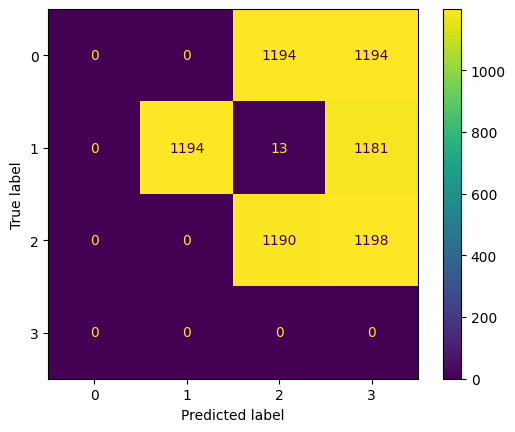

Epoch 5 done. Eval loss: 1.4191422297699976 Eval accuracy: 0.3325892984867096


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 36.72it/s]

Epoch: 6 (0/294) Training loss: 0.7471886595980504


29it [00:00, 44.46it/s]

Epoch: 6 (20/294) Training loss: 0.7480346086648431


49it [00:01, 45.67it/s]

Epoch: 6 (40/294) Training loss: 0.7474149409933172


69it [00:01, 46.12it/s]

Epoch: 6 (60/294) Training loss: 0.747129641341278


89it [00:01, 45.64it/s]

Epoch: 6 (80/294) Training loss: 0.7464855598844706


109it [00:02, 46.51it/s]

Epoch: 6 (100/294) Training loss: 0.7464343262815343


129it [00:02, 46.58it/s]

Epoch: 6 (120/294) Training loss: 0.7463771081441389


149it [00:03, 46.62it/s]

Epoch: 6 (140/294) Training loss: 0.7463101690321283


169it [00:03, 46.29it/s]

Epoch: 6 (160/294) Training loss: 0.746614360084243


189it [00:04, 46.16it/s]

Epoch: 6 (180/294) Training loss: 0.7466182618097921


209it [00:04, 46.71it/s]

Epoch: 6 (200/294) Training loss: 0.7463990597131747


229it [00:05, 45.94it/s]

Epoch: 6 (220/294) Training loss: 0.7465295964414216


249it [00:05, 45.49it/s]

Epoch: 6 (240/294) Training loss: 0.7473916858079248


269it [00:05, 46.37it/s]

Epoch: 6 (260/294) Training loss: 0.7469060066263692


289it [00:06, 46.68it/s]

Epoch: 6 (280/294) Training loss: 0.7463506085816667


294it [00:06, 45.88it/s]


Epoch 6 done. Training loss: 0.7468681986115326 Training accuracy: 0.9997873902320862


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
112it [00:01, 85.40it/s]


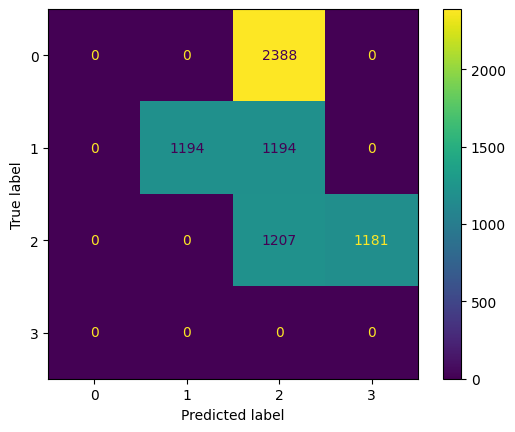

Epoch 6 done. Eval loss: 1.3785950042428998 Eval accuracy: 0.3349609375


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 37.51it/s]

Epoch: 7 (0/294) Training loss: 0.7462878546342988


29it [00:00, 40.94it/s]

Epoch: 7 (20/294) Training loss: 0.746849850759599


49it [00:01, 45.17it/s]

Epoch: 7 (40/294) Training loss: 0.7463761939304885


69it [00:01, 45.58it/s]

Epoch: 7 (60/294) Training loss: 0.7464712185918512


89it [00:02, 46.91it/s]

Epoch: 7 (80/294) Training loss: 0.7496471159681556


109it [00:02, 46.70it/s]

Epoch: 7 (100/294) Training loss: 0.7467530598126871


129it [00:02, 46.64it/s]

Epoch: 7 (120/294) Training loss: 0.7479002682527005


149it [00:03, 46.85it/s]

Epoch: 7 (140/294) Training loss: 0.7464396782813676


169it [00:03, 46.98it/s]

Epoch: 7 (160/294) Training loss: 0.7476995277314266


189it [00:04, 46.86it/s]

Epoch: 7 (180/294) Training loss: 0.7484799168357581


209it [00:04, 47.02it/s]

Epoch: 7 (200/294) Training loss: 0.7460816263523765


229it [00:05, 46.88it/s]

Epoch: 7 (220/294) Training loss: 0.747287435453095


249it [00:05, 47.02it/s]

Epoch: 7 (240/294) Training loss: 0.7463602106885422


269it [00:05, 46.36it/s]

Epoch: 7 (260/294) Training loss: 0.7466906154864527


289it [00:06, 46.60it/s]

Epoch: 7 (280/294) Training loss: 0.7468481172922683


294it [00:06, 45.90it/s]


Epoch 7 done. Training loss: 0.7487537491153252 Training accuracy: 0.9993622303009033


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
112it [00:01, 84.64it/s]


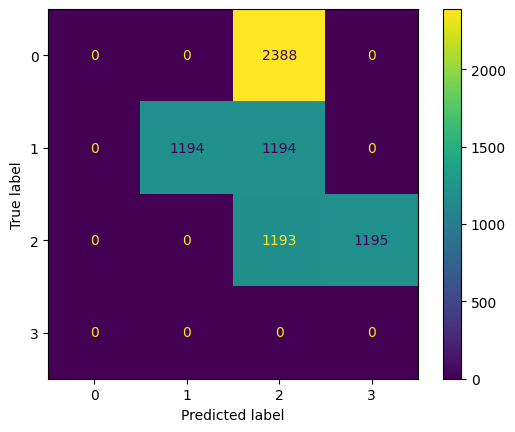

Epoch 7 done. Eval loss: 1.4015304568481823 Eval accuracy: 0.3330078125


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 39.77it/s]

Epoch: 8 (0/294) Training loss: 0.7462809047128416


29it [00:00, 44.52it/s]

Epoch: 8 (20/294) Training loss: 0.7473019652620955


49it [00:01, 45.77it/s]

Epoch: 8 (40/294) Training loss: 0.7474463009829402


69it [00:01, 46.58it/s]

Epoch: 8 (60/294) Training loss: 0.7466395253579051


89it [00:01, 44.97it/s]

Epoch: 8 (80/294) Training loss: 0.7466125687371785


109it [00:02, 46.19it/s]

Epoch: 8 (100/294) Training loss: 0.7470694980010304


129it [00:02, 46.48it/s]

Epoch: 8 (120/294) Training loss: 0.749349245797396


149it [00:03, 46.86it/s]

Epoch: 8 (140/294) Training loss: 0.7468902914048625


169it [00:03, 46.99it/s]

Epoch: 8 (160/294) Training loss: 0.7462754266777376


189it [00:04, 46.51it/s]

Epoch: 8 (180/294) Training loss: 0.7543732450023002


209it [00:04, 46.08it/s]

Epoch: 8 (200/294) Training loss: 0.747189207324269


229it [00:04, 46.26it/s]

Epoch: 8 (220/294) Training loss: 0.7464186072289358


249it [00:05, 46.62it/s]

Epoch: 8 (240/294) Training loss: 0.7468694569505812


269it [00:05, 46.85it/s]

Epoch: 8 (260/294) Training loss: 0.7464419485676539


289it [00:06, 46.94it/s]

Epoch: 8 (280/294) Training loss: 0.7463325889574092


294it [00:06, 46.10it/s]


Epoch 8 done. Training loss: 0.7471598259253067 Training accuracy: 0.9997342824935913


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
112it [00:01, 84.82it/s]


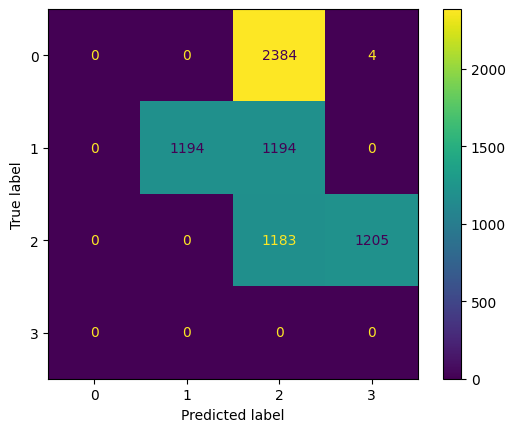

Epoch 8 done. Eval loss: 1.42300592242633 Eval accuracy: 0.3316127359867096


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 38.09it/s]

Epoch: 9 (0/294) Training loss: 0.7460978979271404


29it [00:00, 44.11it/s]

Epoch: 9 (20/294) Training loss: 0.7470706200741817


49it [00:01, 45.49it/s]

Epoch: 9 (40/294) Training loss: 0.7463638178616634


69it [00:01, 45.49it/s]

Epoch: 9 (60/294) Training loss: 0.7483724491595444


89it [00:01, 45.47it/s]

Epoch: 9 (80/294) Training loss: 0.7469095572186868


109it [00:02, 45.69it/s]

Epoch: 9 (100/294) Training loss: 0.7461926074119607


129it [00:02, 46.17it/s]

Epoch: 9 (120/294) Training loss: 0.7463047241279617


149it [00:03, 46.73it/s]

Epoch: 9 (140/294) Training loss: 0.7466935333407134


169it [00:03, 46.67it/s]

Epoch: 9 (160/294) Training loss: 0.7463268935173686


189it [00:04, 46.18it/s]

Epoch: 9 (180/294) Training loss: 0.7472405568177012


209it [00:04, 46.06it/s]

Epoch: 9 (200/294) Training loss: 0.7462030378506244


229it [00:05, 46.28it/s]

Epoch: 9 (220/294) Training loss: 0.7466996263460003


249it [00:05, 46.30it/s]

Epoch: 9 (240/294) Training loss: 0.7462256425667734


269it [00:05, 46.23it/s]

Epoch: 9 (260/294) Training loss: 0.7462225405437175


289it [00:06, 46.11it/s]

Epoch: 9 (280/294) Training loss: 0.7464233900436894


294it [00:06, 45.71it/s]


Epoch 9 done. Training loss: 0.7465592369599253 Training accuracy: 0.9998405575752258


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
112it [00:01, 87.19it/s]


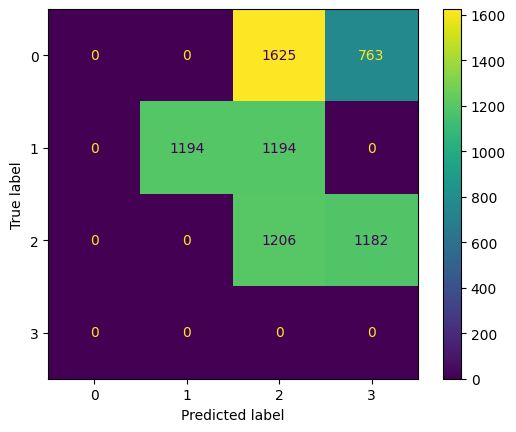

Epoch 9 done. Eval loss: 1.3911725445889083 Eval accuracy: 0.3348214328289032


In [122]:
import torch.nn.functional as f
# LSTM 1
input_dim = 9
hidden_dim = 7 
layer_dim = 1 
output_dim = 4 
dropout_prob = 0
fc_dim = 1120
bi = True
rnn = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim,bi)
optimizer = torch.optim.Adam(rnn.parameters(),lr=1e-3,weight_decay=1e-2)
rnn.double()

criterion = nn.CrossEntropyLoss()

EPOCHS = 10

loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(rnn, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(rnn, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)

0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 35.66it/s]

Epoch: 0 (0/262) Training loss: 1.4384708850257109


28it [00:00, 58.39it/s]

Epoch: 0 (20/262) Training loss: 1.0339638621440126


50it [00:00, 63.60it/s]

Epoch: 0 (40/262) Training loss: 1.1676288145838907


72it [00:01, 66.38it/s]

Epoch: 0 (60/262) Training loss: 0.9986569663814144


94it [00:01, 69.00it/s]

Epoch: 0 (80/262) Training loss: 0.9404904368998755


110it [00:01, 69.50it/s]

Epoch: 0 (100/262) Training loss: 0.9379103299284559


134it [00:02, 74.98it/s]

Epoch: 0 (120/262) Training loss: 0.9440775696316217


150it [00:02, 75.11it/s]

Epoch: 0 (140/262) Training loss: 0.9949394804597129


174it [00:02, 73.92it/s]

Epoch: 0 (160/262) Training loss: 0.9743677661122638


190it [00:02, 75.06it/s]

Epoch: 0 (180/262) Training loss: 0.9907777229089612


215it [00:03, 76.83it/s]

Epoch: 0 (200/262) Training loss: 0.9305494323522798


231it [00:03, 77.42it/s]

Epoch: 0 (220/262) Training loss: 0.9735388643882039


257it [00:03, 79.48it/s]

Epoch: 0 (240/262) Training loss: 0.9191656556858591


262it [00:03, 70.56it/s]


Epoch: 0 (260/262) Training loss: 0.8486256798861342
Epoch 0 done. Training loss: 0.9784541997433228 Training accuracy: 0.6670443415641785


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 132.35it/s]


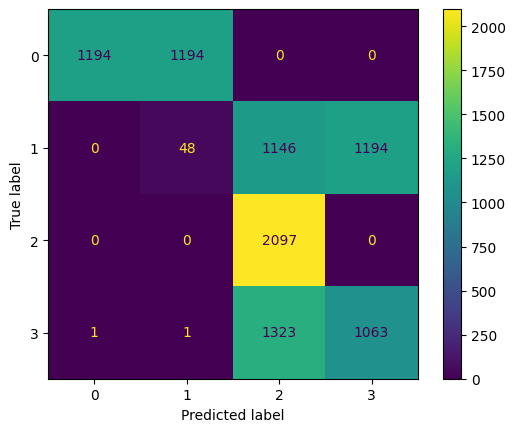

Epoch 0 done. Eval loss: 1.1535098481784891 Eval accuracy: 0.47435346245765686


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 64.55it/s]

Epoch: 1 (0/262) Training loss: 0.884016996693429


31it [00:00, 73.40it/s]

Epoch: 1 (20/262) Training loss: 0.8137776032855162


53it [00:00, 62.98it/s]

Epoch: 1 (40/262) Training loss: 0.7999180897919319


68it [00:01, 67.16it/s]

Epoch: 1 (60/262) Training loss: 0.7843885797570727


91it [00:01, 70.87it/s]

Epoch: 1 (80/262) Training loss: 0.828623553983086


114it [00:01, 68.96it/s]

Epoch: 1 (100/262) Training loss: 0.7955829365748869


129it [00:01, 69.13it/s]

Epoch: 1 (120/262) Training loss: 0.8582074345338665


153it [00:02, 72.59it/s]

Epoch: 1 (140/262) Training loss: 0.8539517220515558


169it [00:02, 71.57it/s]

Epoch: 1 (160/262) Training loss: 0.8224027741981664


185it [00:02, 71.67it/s]

Epoch: 1 (180/262) Training loss: 0.885313793019484


207it [00:03, 58.94it/s]

Epoch: 1 (200/262) Training loss: 0.8072202096125682


228it [00:03, 57.61it/s]

Epoch: 1 (220/262) Training loss: 0.7908892973128403


251it [00:03, 67.56it/s]

Epoch: 1 (240/262) Training loss: 0.8690729836155761


262it [00:03, 66.98it/s]


Epoch: 1 (260/262) Training loss: 0.8223522450491451
Epoch 1 done. Training loss: 0.8302188568532445 Training accuracy: 0.9131679534912109


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 128.43it/s]


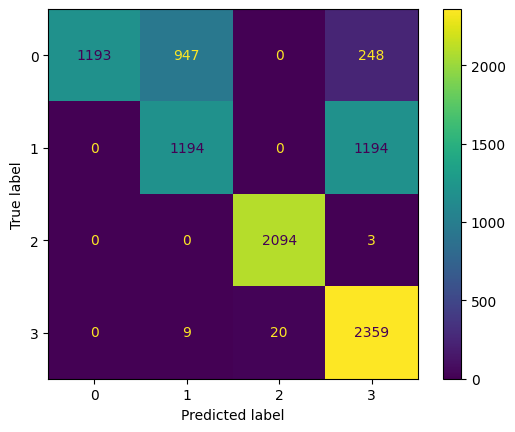

Epoch 1 done. Eval loss: 1.0814446768225605 Eval accuracy: 0.7370689511299133


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
6it [00:00, 59.51it/s]

Epoch: 2 (0/262) Training loss: 0.8220936229809327


29it [00:00, 70.18it/s]

Epoch: 2 (20/262) Training loss: 0.791363496953364


53it [00:00, 69.25it/s]

Epoch: 2 (40/262) Training loss: 0.8241777515590685


76it [00:01, 73.50it/s]

Epoch: 2 (60/262) Training loss: 0.8070479243491997


92it [00:01, 72.04it/s]

Epoch: 2 (80/262) Training loss: 0.8083414622092505


116it [00:01, 75.20it/s]

Epoch: 2 (100/262) Training loss: 0.8535354318297425


132it [00:01, 75.12it/s]

Epoch: 2 (120/262) Training loss: 0.7751417195249961


149it [00:02, 76.57it/s]

Epoch: 2 (140/262) Training loss: 0.8564056729490566


173it [00:02, 75.41it/s]

Epoch: 2 (160/262) Training loss: 0.7595225099847828


181it [00:02, 75.24it/s]

Epoch: 2 (180/262) Training loss: 0.8377540191518644


208it [00:03, 54.18it/s]

Epoch: 2 (200/262) Training loss: 0.7911048992169445


227it [00:03, 55.55it/s]

Epoch: 2 (220/262) Training loss: 0.8376806294604856


251it [00:03, 65.64it/s]

Epoch: 2 (240/262) Training loss: 0.8534039753876385


262it [00:03, 66.24it/s]


Epoch: 2 (260/262) Training loss: 0.8064402889523727
Epoch 2 done. Training loss: 0.8179012267605181 Training accuracy: 0.9235448241233826


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 131.04it/s]


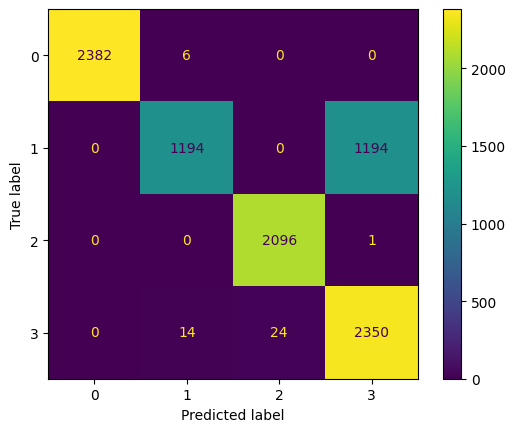

Epoch 2 done. Eval loss: 0.9560596505195712 Eval accuracy: 0.8644396662712097


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
6it [00:00, 54.91it/s]

Epoch: 3 (0/262) Training loss: 0.7907602046752956


28it [00:00, 68.05it/s]

Epoch: 3 (20/262) Training loss: 0.8221387093844343


52it [00:00, 72.58it/s]

Epoch: 3 (40/262) Training loss: 0.915569474837145


76it [00:01, 74.33it/s]

Epoch: 3 (60/262) Training loss: 0.7913953705277016


92it [00:01, 75.18it/s]

Epoch: 3 (80/262) Training loss: 0.7754649740071009


108it [00:01, 75.73it/s]

Epoch: 3 (100/262) Training loss: 0.8216490326852679


132it [00:01, 74.60it/s]

Epoch: 3 (120/262) Training loss: 0.8218988893868504


148it [00:02, 74.43it/s]

Epoch: 3 (140/262) Training loss: 0.8377438681247489


172it [00:02, 74.46it/s]

Epoch: 3 (160/262) Training loss: 0.8063316318895001


197it [00:02, 76.72it/s]

Epoch: 3 (180/262) Training loss: 0.7906483067743256


213it [00:02, 77.61it/s]

Epoch: 3 (200/262) Training loss: 0.8218514874887646


230it [00:03, 78.05it/s]

Epoch: 3 (220/262) Training loss: 0.8374967923498001


254it [00:03, 76.92it/s]

Epoch: 3 (240/262) Training loss: 0.8374710315009462


262it [00:03, 74.49it/s]


Epoch: 3 (260/262) Training loss: 0.7906055211922235
Epoch 3 done. Training loss: 0.8179186012690995 Training accuracy: 0.9224713444709778


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 129.38it/s]


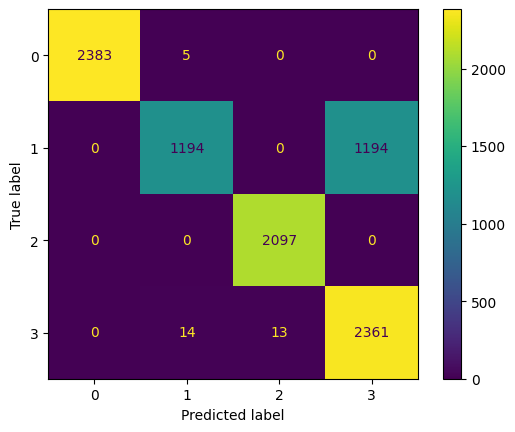

Epoch 3 done. Eval loss: 0.9348591239404447 Eval accuracy: 0.865840494632721


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 67.56it/s]

Epoch: 4 (0/262) Training loss: 0.8374527137342905


30it [00:00, 71.65it/s]

Epoch: 4 (20/262) Training loss: 0.7749767259384754


55it [00:00, 76.35it/s]

Epoch: 4 (40/262) Training loss: 0.8062777031041811


71it [00:00, 75.16it/s]

Epoch: 4 (60/262) Training loss: 0.8999648260057822


95it [00:01, 73.57it/s]

Epoch: 4 (80/262) Training loss: 0.7905762272569994


111it [00:01, 67.77it/s]

Epoch: 4 (100/262) Training loss: 0.8763722993340406


135it [00:01, 69.80it/s]

Epoch: 4 (120/262) Training loss: 0.7756543033078317


151it [00:02, 71.38it/s]

Epoch: 4 (140/262) Training loss: 0.7446525110222598


176it [00:02, 75.32it/s]

Epoch: 4 (160/262) Training loss: 0.7759216874689687


193it [00:02, 75.52it/s]

Epoch: 4 (180/262) Training loss: 0.8203430975551329


209it [00:02, 76.37it/s]

Epoch: 4 (200/262) Training loss: 0.8573191805207684


233it [00:03, 76.48it/s]

Epoch: 4 (220/262) Training loss: 0.8371386676728321


249it [00:03, 76.66it/s]

Epoch: 4 (240/262) Training loss: 0.8844304129272518


262it [00:03, 74.21it/s]


Epoch: 4 (260/262) Training loss: 0.8218684757058541
Epoch 4 done. Training loss: 0.8218549812149262 Training accuracy: 0.9193105697631836


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 128.43it/s]


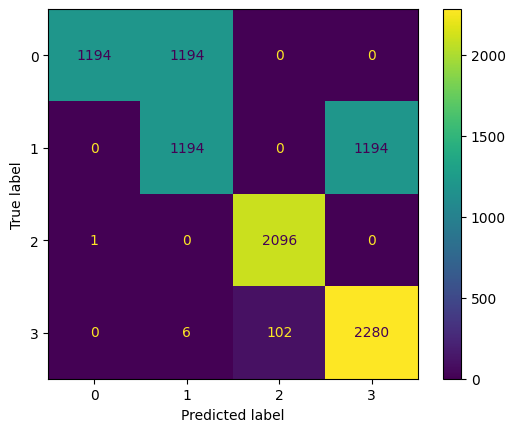

Epoch 4 done. Eval loss: 1.0575973482078718 Eval accuracy: 0.7288793325424194


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 64.33it/s]

Epoch: 5 (0/262) Training loss: 0.790651125705095


31it [00:00, 73.29it/s]

Epoch: 5 (20/262) Training loss: 0.8219929053869285


55it [00:00, 76.40it/s]

Epoch: 5 (40/262) Training loss: 0.8844149392541525


71it [00:00, 75.48it/s]

Epoch: 5 (60/262) Training loss: 0.8064651212749891


95it [00:01, 75.22it/s]

Epoch: 5 (80/262) Training loss: 0.8537816783462809


111it [00:01, 76.11it/s]

Epoch: 5 (100/262) Training loss: 0.8844527162861852


135it [00:01, 75.80it/s]

Epoch: 5 (120/262) Training loss: 0.8218427664067878


151it [00:02, 76.34it/s]

Epoch: 5 (140/262) Training loss: 0.8843096106457523


176it [00:02, 77.77it/s]

Epoch: 5 (160/262) Training loss: 0.8218227980783959


192it [00:02, 77.50it/s]

Epoch: 5 (180/262) Training loss: 0.8531216712882975


217it [00:02, 79.76it/s]

Epoch: 5 (200/262) Training loss: 0.8131344918225307


233it [00:03, 78.17it/s]

Epoch: 5 (220/262) Training loss: 0.8376331153814698


249it [00:03, 77.22it/s]

Epoch: 5 (240/262) Training loss: 0.8687331931466808


262it [00:03, 76.55it/s]


Epoch: 5 (260/262) Training loss: 0.7593070234937714
Epoch 5 done. Training loss: 0.8174643179011565 Training accuracy: 0.9233062863349915


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 133.62it/s]


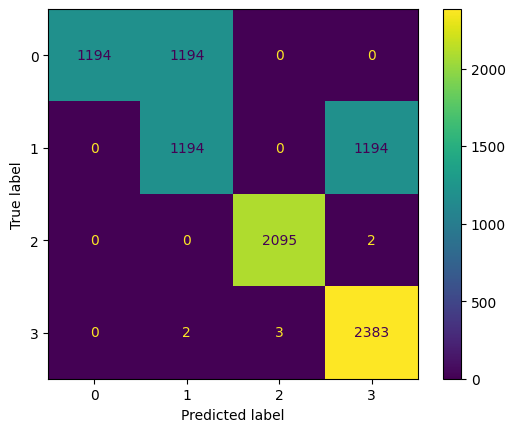

Epoch 5 done. Eval loss: 1.0369187056388198 Eval accuracy: 0.7398706674575806


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 69.81it/s]

Epoch: 6 (0/262) Training loss: 0.774929245553674


31it [00:00, 74.03it/s]

Epoch: 6 (20/262) Training loss: 0.8378958378556057


56it [00:00, 77.32it/s]

Epoch: 6 (40/262) Training loss: 0.8203860608551388


72it [00:00, 71.81it/s]

Epoch: 6 (60/262) Training loss: 0.8532835567885825


94it [00:01, 67.13it/s]

Epoch: 6 (80/262) Training loss: 0.8063049272471707


110it [00:01, 71.14it/s]

Epoch: 6 (100/262) Training loss: 0.8063349428796001


134it [00:01, 70.89it/s]

Epoch: 6 (120/262) Training loss: 0.7594128238260938


150it [00:02, 71.71it/s]

Epoch: 6 (140/262) Training loss: 0.8375904232467816


174it [00:02, 73.35it/s]

Epoch: 6 (160/262) Training loss: 0.8219159738269106


190it [00:02, 75.22it/s]

Epoch: 6 (180/262) Training loss: 0.82185948731735


214it [00:02, 76.71it/s]

Epoch: 6 (200/262) Training loss: 0.8374594412547505


230it [00:03, 76.53it/s]

Epoch: 6 (220/262) Training loss: 0.8219386596634181


254it [00:03, 77.53it/s]

Epoch: 6 (240/262) Training loss: 0.775060790658045


262it [00:03, 73.62it/s]


Epoch: 6 (260/262) Training loss: 0.8531437492967007
Epoch 6 done. Training loss: 0.8178629664038255 Training accuracy: 0.9238430261611938


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 130.15it/s]


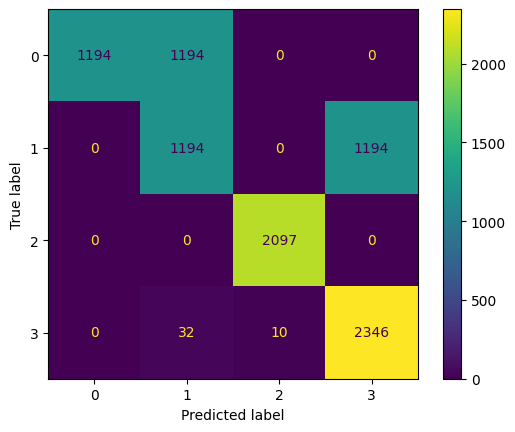

Epoch 6 done. Eval loss: 1.0743145851486924 Eval accuracy: 0.736099123954773


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 65.04it/s]

Epoch: 7 (0/262) Training loss: 0.790726329190822


30it [00:00, 71.81it/s]

Epoch: 7 (20/262) Training loss: 0.8374898223418887


55it [00:00, 71.91it/s]

Epoch: 7 (40/262) Training loss: 0.8218664139291045


71it [00:00, 71.42it/s]

Epoch: 7 (60/262) Training loss: 0.7906703054009154


96it [00:01, 75.95it/s]

Epoch: 7 (80/262) Training loss: 0.8686895376611237


112it [00:01, 76.77it/s]

Epoch: 7 (100/262) Training loss: 0.7751433117281461


128it [00:01, 76.05it/s]

Epoch: 7 (120/262) Training loss: 0.7906257007599552


154it [00:02, 77.73it/s]

Epoch: 7 (140/262) Training loss: 0.7906170393725789


170it [00:02, 77.44it/s]

Epoch: 7 (160/262) Training loss: 0.8374481174288251


194it [00:02, 77.31it/s]

Epoch: 7 (180/262) Training loss: 0.8062398050452364


210it [00:02, 77.87it/s]

Epoch: 7 (200/262) Training loss: 0.7750364453542511


235it [00:03, 77.13it/s]

Epoch: 7 (220/262) Training loss: 0.8374660093314775


252it [00:03, 77.93it/s]

Epoch: 7 (240/262) Training loss: 0.774956406296929


262it [00:03, 75.98it/s]


Epoch: 7 (260/262) Training loss: 0.837454718782815
Epoch 7 done. Training loss: 0.8150900281335193 Training accuracy: 0.9256321787834167


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 130.87it/s]


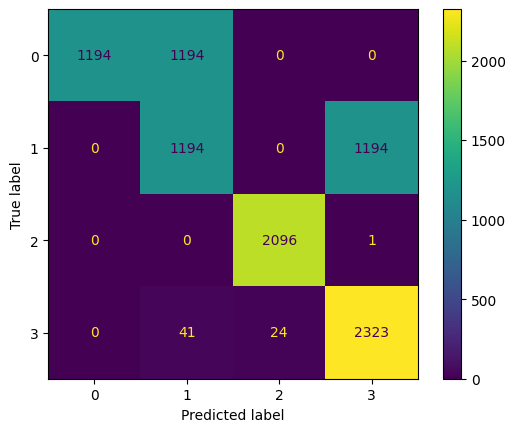

Epoch 7 done. Eval loss: 1.0759310137194247 Eval accuracy: 0.7335129380226135


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 67.75it/s]

Epoch: 8 (0/262) Training loss: 0.821822072096807


30it [00:00, 73.51it/s]

Epoch: 8 (20/262) Training loss: 0.7752802196818624


54it [00:00, 75.83it/s]

Epoch: 8 (40/262) Training loss: 0.8530659031014931


70it [00:00, 75.28it/s]

Epoch: 8 (60/262) Training loss: 0.7593931959967088


86it [00:01, 63.78it/s]

Epoch: 8 (80/262) Training loss: 0.7749536262825003


109it [00:01, 68.28it/s]

Epoch: 8 (100/262) Training loss: 0.7594072917200325


133it [00:01, 74.68it/s]

Epoch: 8 (120/262) Training loss: 0.8062916585637611


149it [00:02, 75.30it/s]

Epoch: 8 (140/262) Training loss: 0.8062124329658348


173it [00:02, 76.46it/s]

Epoch: 8 (160/262) Training loss: 0.8218297698876385


189it [00:02, 77.56it/s]

Epoch: 8 (180/262) Training loss: 0.8531076667850583


214it [00:02, 78.18it/s]

Epoch: 8 (200/262) Training loss: 0.8062728125688989


230it [00:03, 78.21it/s]

Epoch: 8 (220/262) Training loss: 0.8530627287860322


255it [00:03, 77.18it/s]

Epoch: 8 (240/262) Training loss: 0.8375127942227174


262it [00:03, 74.32it/s]


Epoch: 8 (260/262) Training loss: 0.9352169898688456
Epoch 8 done. Training loss: 0.8191152899192267 Training accuracy: 0.9221732020378113


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 132.02it/s]


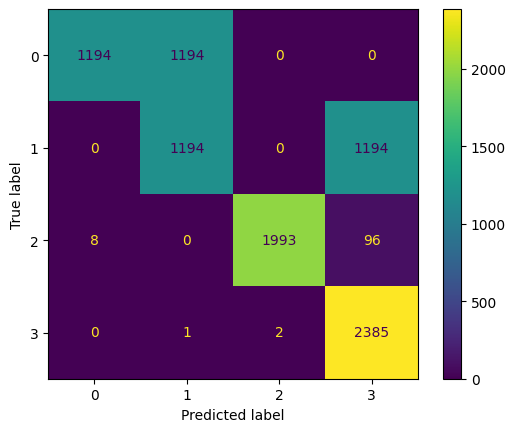

Epoch 8 done. Eval loss: 1.0833104750461986 Eval accuracy: 0.7290948033332825


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 64.50it/s]

Epoch: 9 (0/262) Training loss: 0.9176802259835879


31it [00:00, 74.46it/s]

Epoch: 9 (20/262) Training loss: 0.8375407354236883


55it [00:00, 76.02it/s]

Epoch: 9 (40/262) Training loss: 0.8063171725017022


71it [00:00, 75.22it/s]

Epoch: 9 (60/262) Training loss: 0.8530974166733257


95it [00:01, 76.87it/s]

Epoch: 9 (80/262) Training loss: 0.822353429034463


112it [00:01, 78.25it/s]

Epoch: 9 (100/262) Training loss: 0.7749861308516395


136it [00:01, 78.37it/s]

Epoch: 9 (120/262) Training loss: 0.8530528139447521


152it [00:01, 77.31it/s]

Epoch: 9 (140/262) Training loss: 0.7905524726666061


176it [00:02, 77.89it/s]

Epoch: 9 (160/262) Training loss: 0.8530514609257296


192it [00:02, 76.86it/s]

Epoch: 9 (180/262) Training loss: 0.8374230874331552


209it [00:02, 78.57it/s]

Epoch: 9 (200/262) Training loss: 0.774923272480199


234it [00:03, 78.64it/s]

Epoch: 9 (220/262) Training loss: 0.7905492591145318


250it [00:03, 78.43it/s]

Epoch: 9 (240/262) Training loss: 0.884297837702145


262it [00:03, 76.99it/s]


Epoch: 9 (260/262) Training loss: 0.7594310478540935
Epoch 9 done. Training loss: 0.8240753412880786 Training accuracy: 0.9168654680252075


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 132.26it/s]


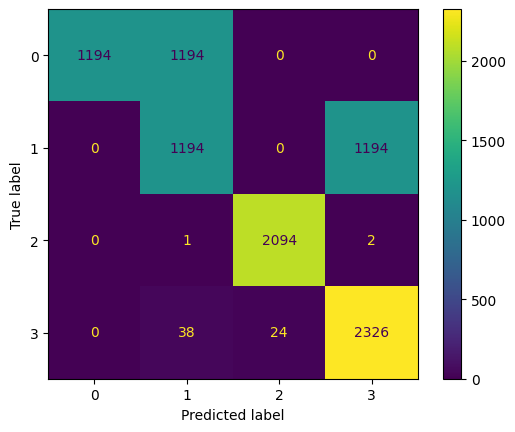

Epoch 9 done. Eval loss: 1.0564425892478404 Eval accuracy: 0.7336207032203674


In [93]:
import torch.nn.functional as f
# LSTM 1
input_dim = 9
hidden_dim = 6 
layer_dim = 1 
output_dim = 4 
dropout_prob = 0
bi = False
fc_dim = 480
rnn = GRUModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bi)
optimizer = torch.optim.Adam(rnn.parameters(),lr=1e-2,weight_decay=0)
rnn.double()

criterion = nn.CrossEntropyLoss()

EPOCHS = 10

loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(rnn, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(rnn, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)

0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
8it [00:00, 40.65it/s]

Epoch: 0 (0/262) Training loss: 1.4179180578154844


29it [00:00, 47.74it/s]

Epoch: 0 (20/262) Training loss: 1.0315612796989735


49it [00:01, 48.92it/s]

Epoch: 0 (40/262) Training loss: 1.021818418836257


69it [00:01, 48.43it/s]

Epoch: 0 (60/262) Training loss: 0.8403345266498081


91it [00:01, 49.81it/s]

Epoch: 0 (80/262) Training loss: 0.8149574297841731


107it [00:02, 49.66it/s]

Epoch: 0 (100/262) Training loss: 0.797031157380942


129it [00:02, 50.31it/s]

Epoch: 0 (120/262) Training loss: 0.8043229228038472


147it [00:03, 45.78it/s]

Epoch: 0 (140/262) Training loss: 0.7744918982906436


167it [00:03, 46.49it/s]

Epoch: 0 (160/262) Training loss: 0.7771077119321022


189it [00:03, 49.31it/s]

Epoch: 0 (180/262) Training loss: 0.7868005244483054


207it [00:04, 50.35it/s]

Epoch: 0 (200/262) Training loss: 0.7635714347254379


229it [00:04, 50.26it/s]

Epoch: 0 (220/262) Training loss: 0.7694587381685191


247it [00:05, 50.39it/s]

Epoch: 0 (240/262) Training loss: 0.7529795290131739


262it [00:05, 48.67it/s]


Epoch: 0 (260/262) Training loss: 0.7511520733023248
Epoch 0 done. Training loss: 0.8379198614190414 Training accuracy: 0.9358301758766174


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 102.51it/s]


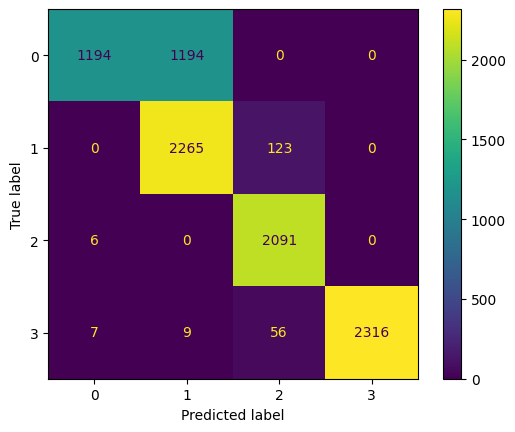

Epoch 0 done. Eval loss: 0.947635714763806 Eval accuracy: 0.8476293087005615


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
5it [00:00, 43.36it/s]

Epoch: 1 (0/262) Training loss: 0.7543347914460008


27it [00:00, 48.70it/s]

Epoch: 1 (20/262) Training loss: 0.7674121836301857


48it [00:00, 49.78it/s]

Epoch: 1 (40/262) Training loss: 0.7577483854074852


71it [00:01, 49.81it/s]

Epoch: 1 (60/262) Training loss: 0.7661456012638945


89it [00:01, 50.39it/s]

Epoch: 1 (80/262) Training loss: 0.7498207071961739


107it [00:02, 50.59it/s]

Epoch: 1 (100/262) Training loss: 0.7517906972602938


131it [00:02, 50.57it/s]

Epoch: 1 (120/262) Training loss: 0.7498865461086804


149it [00:02, 50.68it/s]

Epoch: 1 (140/262) Training loss: 0.7473459764077721


167it [00:03, 50.51it/s]

Epoch: 1 (160/262) Training loss: 0.7476268190894024


191it [00:03, 50.72it/s]

Epoch: 1 (180/262) Training loss: 0.749129832018415


209it [00:04, 51.03it/s]

Epoch: 1 (200/262) Training loss: 0.7490662402521755


227it [00:04, 51.26it/s]

Epoch: 1 (220/262) Training loss: 0.7471802132759309


251it [00:04, 51.16it/s]

Epoch: 1 (240/262) Training loss: 0.7471404733384761


262it [00:05, 50.27it/s]


Epoch: 1 (260/262) Training loss: 0.7478874903502385
Epoch 1 done. Training loss: 0.7522995440109906 Training accuracy: 0.9944537281990051


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 99.57it/s] 


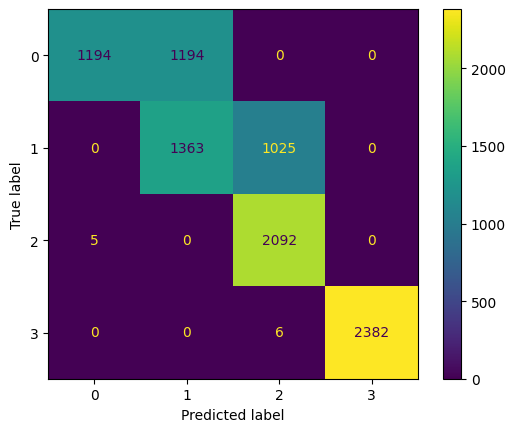

Epoch 1 done. Eval loss: 0.9671658091044288 Eval accuracy: 0.7576508522033691


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 38.70it/s]

Epoch: 2 (0/262) Training loss: 0.751882055937273


30it [00:00, 47.34it/s]

Epoch: 2 (20/262) Training loss: 0.7471833847104561


50it [00:01, 48.05it/s]

Epoch: 2 (40/262) Training loss: 0.7474717432270059


67it [00:01, 49.67it/s]

Epoch: 2 (60/262) Training loss: 0.7475324009343078


90it [00:01, 50.47it/s]

Epoch: 2 (80/262) Training loss: 0.7461020807269678


108it [00:02, 50.35it/s]

Epoch: 2 (100/262) Training loss: 0.7469964090386801


130it [00:02, 44.68it/s]

Epoch: 2 (120/262) Training loss: 0.7451429147521804


146it [00:03, 47.36it/s]

Epoch: 2 (140/262) Training loss: 0.7455762285847206


169it [00:03, 49.75it/s]

Epoch: 2 (160/262) Training loss: 0.7451784008875859


191it [00:03, 50.19it/s]

Epoch: 2 (180/262) Training loss: 0.7477916267124003


209it [00:04, 49.70it/s]

Epoch: 2 (200/262) Training loss: 0.7450354215430077


230it [00:04, 49.84it/s]

Epoch: 2 (220/262) Training loss: 0.7453038218417006


251it [00:05, 49.48it/s]

Epoch: 2 (240/262) Training loss: 0.7474383560345197


262it [00:05, 48.54it/s]


Epoch: 2 (260/262) Training loss: 0.7455337405383591
Epoch 2 done. Training loss: 0.7474166396798432 Training accuracy: 0.9955868124961853


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 97.75it/s]


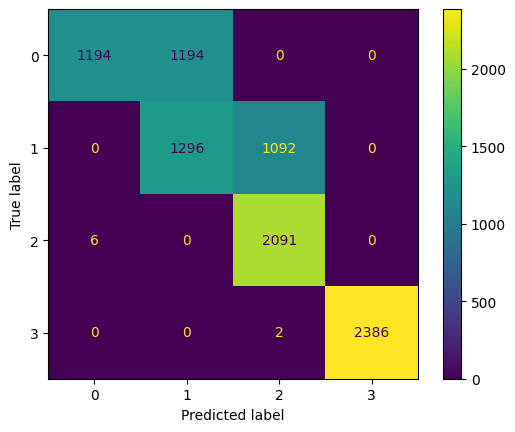

Epoch 2 done. Eval loss: 0.9647871268183226 Eval accuracy: 0.7507542967796326


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
5it [00:00, 40.60it/s]

Epoch: 3 (0/262) Training loss: 0.75126229976561


25it [00:00, 46.89it/s]

Epoch: 3 (20/262) Training loss: 0.7448437084130256


46it [00:00, 48.82it/s]

Epoch: 3 (40/262) Training loss: 0.7473075987068644


68it [00:01, 48.80it/s]

Epoch: 3 (60/262) Training loss: 0.7449731984181941


86it [00:01, 49.73it/s]

Epoch: 3 (80/262) Training loss: 0.7455784980896825


108it [00:02, 49.87it/s]

Epoch: 3 (100/262) Training loss: 0.7449768794375833


129it [00:02, 49.89it/s]

Epoch: 3 (120/262) Training loss: 0.7600476318689652


149it [00:03, 49.09it/s]

Epoch: 3 (140/262) Training loss: 0.7449301606451109


170it [00:03, 48.60it/s]

Epoch: 3 (160/262) Training loss: 0.7453476363465072


191it [00:03, 49.21it/s]

Epoch: 3 (180/262) Training loss: 0.7442999001978792


209it [00:04, 49.88it/s]

Epoch: 3 (200/262) Training loss: 0.7448895388208063


226it [00:04, 50.38it/s]

Epoch: 3 (220/262) Training loss: 0.7442426392025956


250it [00:05, 50.11it/s]

Epoch: 3 (240/262) Training loss: 0.7446193783280994


262it [00:05, 49.24it/s]


Epoch: 3 (260/262) Training loss: 0.7445911515071236
Epoch 3 done. Training loss: 0.7461505288835287 Training accuracy: 0.9955868124961853


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 101.88it/s]


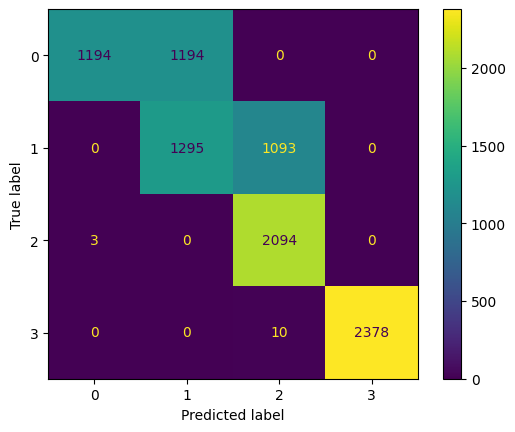

Epoch 3 done. Eval loss: 0.9795784318292126 Eval accuracy: 0.7501077651977539


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
5it [00:00, 44.72it/s]

Epoch: 4 (0/262) Training loss: 0.744465098579152


27it [00:00, 48.74it/s]

Epoch: 4 (20/262) Training loss: 0.7443806196638221


49it [00:01, 49.67it/s]

Epoch: 4 (40/262) Training loss: 0.744472614614468


66it [00:01, 49.87it/s]

Epoch: 4 (60/262) Training loss: 0.7601576887548005


89it [00:01, 49.66it/s]

Epoch: 4 (80/262) Training loss: 0.7443716084475488


109it [00:02, 48.10it/s]

Epoch: 4 (100/262) Training loss: 0.7458657928483166


130it [00:02, 48.34it/s]

Epoch: 4 (120/262) Training loss: 0.7443125288717065


151it [00:03, 49.40it/s]

Epoch: 4 (140/262) Training loss: 0.7445182413401875


168it [00:03, 49.89it/s]

Epoch: 4 (160/262) Training loss: 0.744748965849953


191it [00:03, 50.06it/s]

Epoch: 4 (180/262) Training loss: 0.7444320067984643


209it [00:04, 50.04it/s]

Epoch: 4 (200/262) Training loss: 0.7441611229825201


227it [00:04, 50.61it/s]

Epoch: 4 (220/262) Training loss: 0.7445414764219067


245it [00:04, 50.73it/s]

Epoch: 4 (240/262) Training loss: 0.7445120788351012


262it [00:05, 49.23it/s]


Epoch: 4 (260/262) Training loss: 0.7440728744568461
Epoch 4 done. Training loss: 0.7453106519168099 Training accuracy: 0.9961235523223877


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 102.34it/s]


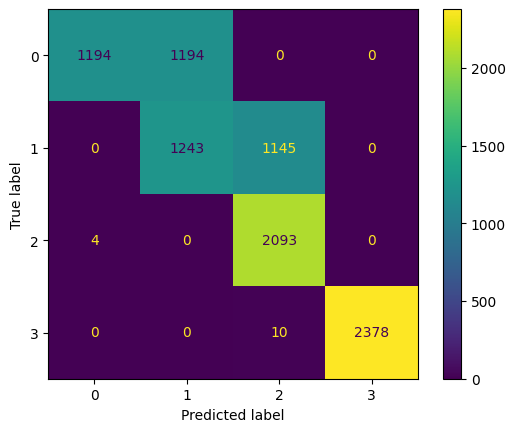

Epoch 4 done. Eval loss: 0.9893558584711082 Eval accuracy: 0.7443965673446655


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 39.42it/s]

Epoch: 5 (0/262) Training loss: 0.745754848138123


30it [00:00, 48.25it/s]

Epoch: 5 (20/262) Training loss: 0.7439394178216453


50it [00:01, 49.07it/s]

Epoch: 5 (40/262) Training loss: 0.744751969751704


66it [00:01, 48.78it/s]

Epoch: 5 (60/262) Training loss: 0.7493181840721993


87it [00:01, 49.73it/s]

Epoch: 5 (80/262) Training loss: 0.7596260821548919


110it [00:02, 50.00it/s]

Epoch: 5 (100/262) Training loss: 0.7441934000762362


127it [00:02, 49.35it/s]

Epoch: 5 (120/262) Training loss: 0.7445947641054165


147it [00:03, 48.73it/s]

Epoch: 5 (140/262) Training loss: 0.7446136308262221


168it [00:03, 49.12it/s]

Epoch: 5 (160/262) Training loss: 0.7440323215628867


189it [00:03, 48.36it/s]

Epoch: 5 (180/262) Training loss: 0.7441530090656534


211it [00:04, 49.22it/s]

Epoch: 5 (200/262) Training loss: 0.7442376820307263


226it [00:04, 49.11it/s]

Epoch: 5 (220/262) Training loss: 0.7440356014224558


250it [00:05, 50.38it/s]

Epoch: 5 (240/262) Training loss: 0.7440151394927278


262it [00:05, 48.77it/s]


Epoch: 5 (260/262) Training loss: 0.7440697357320322
Epoch 5 done. Training loss: 0.7451641420973923 Training accuracy: 0.9960042834281921


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 102.18it/s]


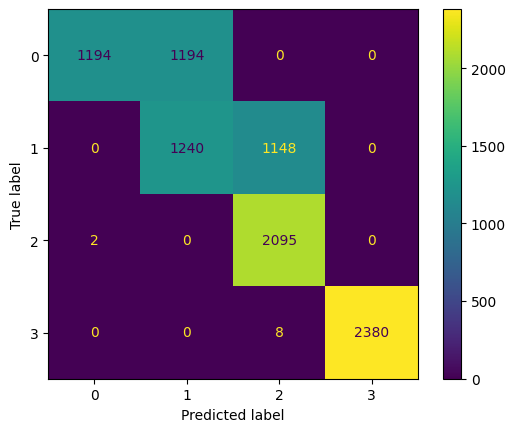

Epoch 5 done. Eval loss: 0.9879821110299606 Eval accuracy: 0.7445043325424194


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 37.86it/s]

Epoch: 6 (0/262) Training loss: 0.74473975712358


30it [00:00, 47.94it/s]

Epoch: 6 (20/262) Training loss: 0.7442911497888538


51it [00:01, 48.95it/s]

Epoch: 6 (40/262) Training loss: 0.7441648221536026


68it [00:01, 49.36it/s]

Epoch: 6 (60/262) Training loss: 0.7439834803285305


91it [00:01, 50.00it/s]

Epoch: 6 (80/262) Training loss: 0.7453100892720995


109it [00:02, 50.80it/s]

Epoch: 6 (100/262) Training loss: 0.7441607263201866


127it [00:02, 50.94it/s]

Epoch: 6 (120/262) Training loss: 0.7439459116521648


151it [00:03, 50.75it/s]

Epoch: 6 (140/262) Training loss: 0.7438794977244503


169it [00:03, 50.52it/s]

Epoch: 6 (160/262) Training loss: 0.7439611964255212


190it [00:03, 48.51it/s]

Epoch: 6 (180/262) Training loss: 0.7441323444550005


206it [00:04, 49.02it/s]

Epoch: 6 (200/262) Training loss: 0.744045947118893


226it [00:04, 48.98it/s]

Epoch: 6 (220/262) Training loss: 0.7441285205107823


250it [00:05, 50.13it/s]

Epoch: 6 (240/262) Training loss: 0.7438257529769972


262it [00:05, 49.37it/s]


Epoch: 6 (260/262) Training loss: 0.7439982652796504
Epoch 6 done. Training loss: 0.7445107053144542 Training accuracy: 0.996421754360199


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 102.01it/s]


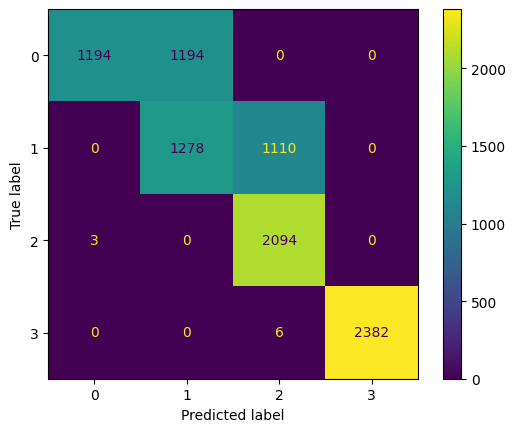

Epoch 6 done. Eval loss: 0.9866710373242673 Eval accuracy: 0.7487068772315979


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
5it [00:00, 43.49it/s]

Epoch: 7 (0/262) Training loss: 0.7439636737867618


31it [00:00, 48.99it/s]

Epoch: 7 (20/262) Training loss: 0.7444417633896432


48it [00:00, 49.73it/s]

Epoch: 7 (40/262) Training loss: 0.7441217354491994


66it [00:01, 50.53it/s]

Epoch: 7 (60/262) Training loss: 0.7438674785692296


90it [00:01, 51.05it/s]

Epoch: 7 (80/262) Training loss: 0.7440242777337686


108it [00:02, 50.40it/s]

Epoch: 7 (100/262) Training loss: 0.74401887719298


130it [00:02, 46.55it/s]

Epoch: 7 (120/262) Training loss: 0.7440973962489627


145it [00:02, 47.25it/s]

Epoch: 7 (140/262) Training loss: 0.7442474602732175


166it [00:03, 48.27it/s]

Epoch: 7 (160/262) Training loss: 0.7440786319967423


187it [00:03, 48.80it/s]

Epoch: 7 (180/262) Training loss: 0.743902895940824


207it [00:04, 49.15it/s]

Epoch: 7 (200/262) Training loss: 0.7438906038346896


229it [00:04, 49.30it/s]

Epoch: 7 (220/262) Training loss: 0.743954623911498


250it [00:05, 49.10it/s]

Epoch: 7 (240/262) Training loss: 0.7438927017346488


262it [00:05, 48.69it/s]


Epoch: 7 (260/262) Training loss: 0.7450365066632897
Epoch 7 done. Training loss: 0.7445397596489456 Training accuracy: 0.9962428212165833


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 101.85it/s]


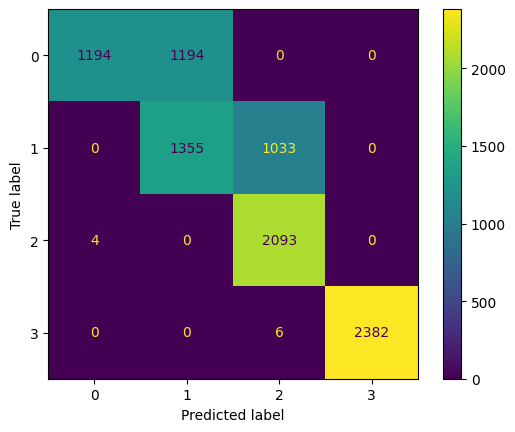

Epoch 7 done. Eval loss: 0.9832093736782191 Eval accuracy: 0.7568965554237366


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 38.65it/s]

Epoch: 8 (0/262) Training loss: 0.7438805181440729


26it [00:00, 48.20it/s]

Epoch: 8 (20/262) Training loss: 0.7439991854265731


49it [00:01, 49.83it/s]

Epoch: 8 (40/262) Training loss: 0.7439415865710646


67it [00:01, 49.96it/s]

Epoch: 8 (60/262) Training loss: 0.7440066117048888


89it [00:01, 49.00it/s]

Epoch: 8 (80/262) Training loss: 0.7501036233511422


106it [00:02, 50.00it/s]

Epoch: 8 (100/262) Training loss: 0.7439186080845687


130it [00:02, 50.65it/s]

Epoch: 8 (120/262) Training loss: 0.7456931204145761


148it [00:02, 49.97it/s]

Epoch: 8 (140/262) Training loss: 0.745905424140369


171it [00:03, 50.37it/s]

Epoch: 8 (160/262) Training loss: 0.7439252555648965


189it [00:03, 50.27it/s]

Epoch: 8 (180/262) Training loss: 0.7441629573972623


207it [00:04, 50.10it/s]

Epoch: 8 (200/262) Training loss: 0.7590416054089449


231it [00:04, 50.71it/s]

Epoch: 8 (220/262) Training loss: 0.7446182992079401


249it [00:05, 50.61it/s]

Epoch: 8 (240/262) Training loss: 0.7476416205586245


262it [00:05, 49.85it/s]


Epoch: 8 (260/262) Training loss: 0.74388992414827
Epoch 8 done. Training loss: 0.7445116029315528 Training accuracy: 0.9965410232543945


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 101.78it/s]


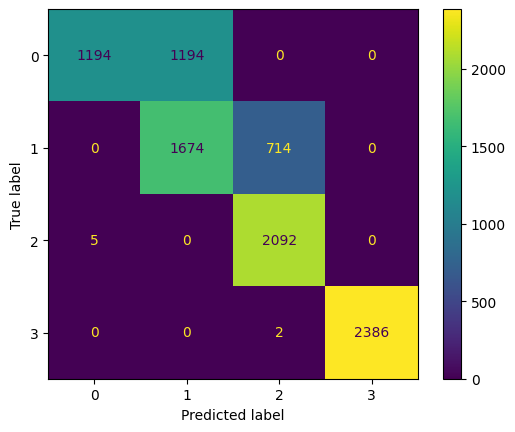

Epoch 8 done. Eval loss: 0.9793600559520769 Eval accuracy: 0.7915948033332825


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)


Epoch: 9 (0/262) Training loss: 0.7438612228644943


28it [00:00, 42.14it/s]

Epoch: 9 (20/262) Training loss: 0.7439496825977985


48it [00:01, 45.71it/s]

Epoch: 9 (40/262) Training loss: 0.7442292741797862


68it [00:01, 47.04it/s]

Epoch: 9 (60/262) Training loss: 0.7440305302531283


88it [00:02, 45.40it/s]

Epoch: 9 (80/262) Training loss: 0.7438548994000374


108it [00:02, 45.29it/s]

Epoch: 9 (100/262) Training loss: 0.7437679963050534


128it [00:02, 47.09it/s]

Epoch: 9 (120/262) Training loss: 0.7439580832121908


148it [00:03, 47.05it/s]

Epoch: 9 (140/262) Training loss: 0.7437534376357492


168it [00:03, 48.27it/s]

Epoch: 9 (160/262) Training loss: 0.7438448968905659


188it [00:04, 48.46it/s]

Epoch: 9 (180/262) Training loss: 0.7471535078507577


210it [00:04, 49.53it/s]

Epoch: 9 (200/262) Training loss: 0.7438551609409237


227it [00:05, 49.90it/s]

Epoch: 9 (220/262) Training loss: 0.7442422884140485


248it [00:05, 49.52it/s]

Epoch: 9 (240/262) Training loss: 0.7437710577052057


262it [00:05, 45.95it/s]


Epoch: 9 (260/262) Training loss: 0.7438595010168626
Epoch 9 done. Training loss: 0.7443404767674074 Training accuracy: 0.9965410232543945


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_60903/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
145it [00:01, 102.58it/s]


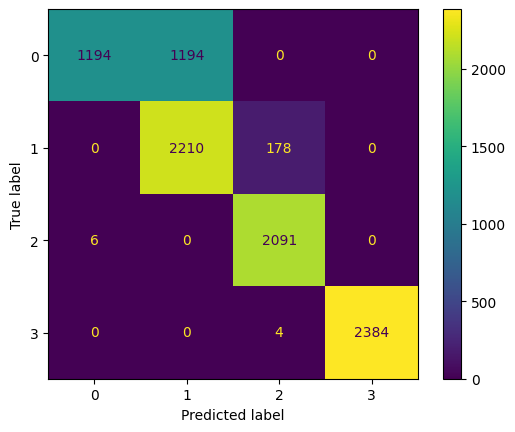

Epoch 9 done. Eval loss: 0.9769111162195221 Eval accuracy: 0.8490301966667175


In [96]:
# GRU 1
input_dim = 9
hidden_dim = 6 
layer_dim = 1 
output_dim = 4 
dropout_prob = 0
bi = True
fc_dim = 960
rnn = GRUModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bi)
optimizer = torch.optim.Adam(rnn.parameters(),lr=1e-3,weight_decay=0)
rnn.double()

criterion = nn.CrossEntropyLoss()

EPOCHS = 10

loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(rnn, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(rnn, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)